In [1]:
#Importing needed packages
import numpy as np
import astropy
import matplotlib.pyplot as plt
from helita.sim import rh15d
from astropy.io import fits
from matplotlib import cm
import h5py
from scipy.io import readsav
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.image import NonUniformImage
import pandas as pd
import sunpy.cm as cm
import seaborn as sns

In [26]:
#Define functions in the beginning of the programme
def radiation_temperature(lambda_ref, I_sp):
    """Compute the radiation/brightness temperature 
    from specific intensity"""
    h =6.62607015e-34 #J-s
    c = 3.0e8 #m/s
    k_b = 1.380649e-23 # J/K
    N_r = (h*c)/(lambda_ref*k_b)
    vary = (2*h*c**2)/(lambda_ref**5)
    D_r = np.log((vary/(I_sp*c/lambda_ref**2)+1))
    T_rad = N_r/D_r
    return T_rad

In [5]:
dpath_trans = '/mn/stornext/u3/souvikb/'
dpath_qs_sim= '/mn/stornext/d9/souvikb/'
input_sim = h5py.File(dpath_qs_sim+'qs024031_by200_800.hdf5','r')

In [6]:
input_sim.keys()

<KeysViewHDF5 ['B_x', 'B_y', 'B_z', 'electron_density', 'hydrogen_populations', 'snapshot_number', 'temperature', 'velocity_z', 'x', 'y', 'z']>

In [7]:
temp_gas = input_sim['temperature']
vel_gas=input_sim['velocity_z']
z    = input_sim['z']#Height (m)
x    = input_sim['x']#Spatial [m]
y    = input_sim['y']# Spatial [m]

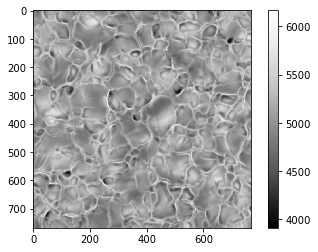

In [8]:
plt.imshow(temp_gas[0,:,:,600],cmap="Greys_r")
plt.colorbar()

In [9]:
dpath_part_1 = '/mn/stornext/d9/souvikb/Big_Ca_run/cube_0-384_by_768_800-802/'
dpath_part_2 = '/mn/stornext/d9/souvikb/Big_Ca_run/cube_385-768_by_768_800-802/'

In [10]:
data_n1_s800 = h5py.File(dpath_part_1+'output_ray_CaII_PRD_s800.hdf5')
data_n2_s800 = h5py.File(dpath_part_2+'output_ray_CaII_PRD_s800.hdf5')

In [11]:
Ca_wb_1 = np.array(data_n1_s800['intensity'])
Ca_wb_2 = np.array(data_n2_s800['intensity'])

In [12]:
wave_wb = np.array(data_n1_s800['wavelength'])
indices = np.arange(len(wave_wb))[(wave_wb>393.5 ) & (wave_wb < 396.5)]

In [13]:
inten_comb=np.concatenate((Ca_wb_1,Ca_wb_2),axis=0)

In [14]:
file =dpath_trans+r'CHROMIS_WB.xls'
df = pd.read_excel(file)
wave_chrom = np.array(df['wave'])
Transmission_chrom = np.array(df['Trans'])

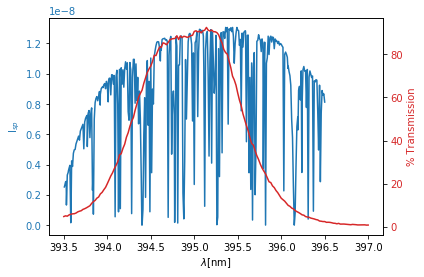

In [15]:
fig,ax= plt.subplots()
color = 'tab:blue'
ax.set_ylabel(r'I$_{sp}$',color=color)
ax.set_xlabel(r'$\lambda$[nm]')
ax.plot(wave_wb[indices],inten_comb[200,200,indices],color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2=ax.twinx()
color ='tab:red'
ax2.set_ylabel('% Transmission',color=color)
ax2.plot(wave_chrom,Transmission_chrom,color=color)
ax2.tick_params(axis='y', labelcolor=color)

In [16]:
tau_height1 = data_n1_s800['tau_one_height']
tau_height2 = data_n2_s800['tau_one_height']

In [17]:
tau_comb = np.concatenate((tau_height1,tau_height2),axis=0)

In [18]:
size_intensity=inten_comb.shape
size_tau = tau_comb.shape

In [19]:
#Backtracking from Mats
wave_wb[indices[126]]

394.6099789582211

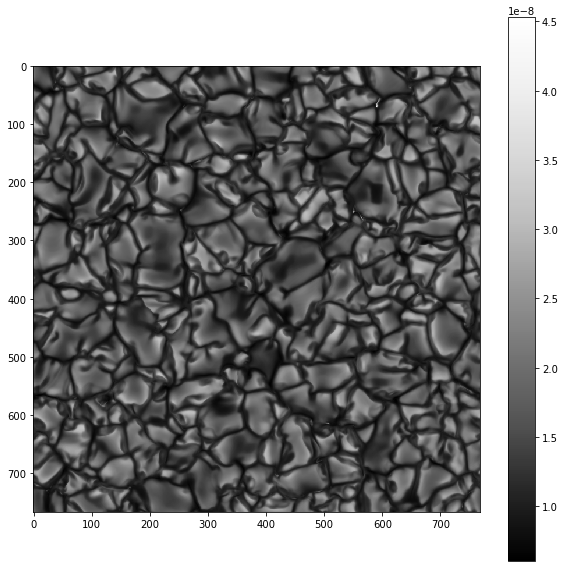

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(inten_comb[:,:,indices[126]],cmap='Greys_r')
plt.colorbar()
I_ref = inten_comb[:,:,indices[126]]

In [27]:
lamba_ref = 394.61e-9
I_sp = I_ref
T_brightness_ref = I_sp*0.
for xx in range(size_intensity[0]):
    for yy in range(size_intensity[1]):
        T_brightness_ref[xx,yy] = radiation_temperature(lambda_ref=lamba_ref,I_sp=I_sp[xx,yy])

6023.995

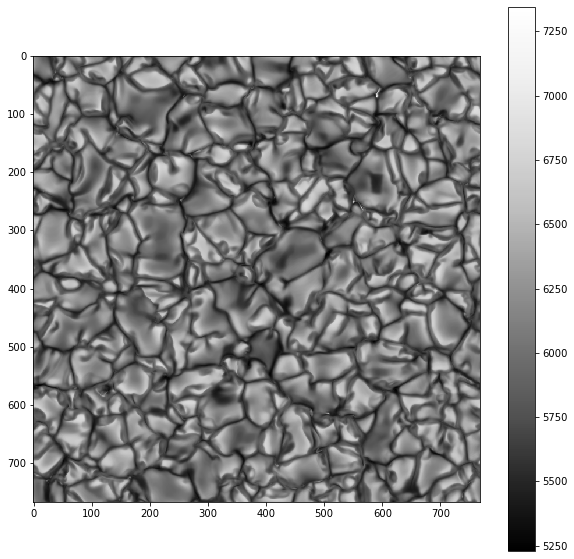

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(T_brightness_ref,cmap='Greys_r')
plt.colorbar()
np.mean(T_brightness_ref)

In [30]:
Tau_ht=tau_comb[:,:,indices[126]]

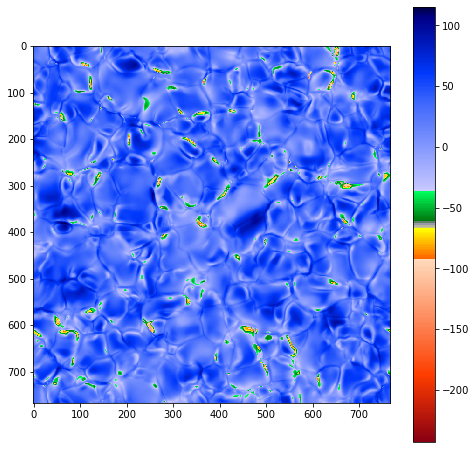

In [31]:
hmi_mag=plt.get_cmap('hmimag')
plt.figure(figsize=(8,8))
plt.imshow(Tau_ht/1e3,cmap=hmi_mag)
plt.colorbar()

In [25]:
temp_gas

<HDF5 dataset "temperature": shape (1, 768, 768, 768), type "<f4">

In [32]:
def find_nearest(array, value):
    """Finding the closest value in 
    an array"""
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
array = np.random.random(10)
value = 0.5
print(array)
print(find_nearest(array, value))

[0.81710984 0.16923706 0.82772848 0.70833934 0.22716886 0.94169366
 0.47150347 0.98641217 0.71112882 0.38623284]
6


In [33]:
T_gas_tau = Tau_ht*0
for ii in range(768):
    for jj in range(768):
        idx = find_nearest(z[0,:],Tau_ht[ii,jj])
        T_gas_tau[ii,jj]= temp_gas[0,ii,jj,idx]
        if temp_gas[0,ii,jj,idx] == 0:
            print(format(ii),format(jj),idx,temp_gas[0,ii,jj,idx])

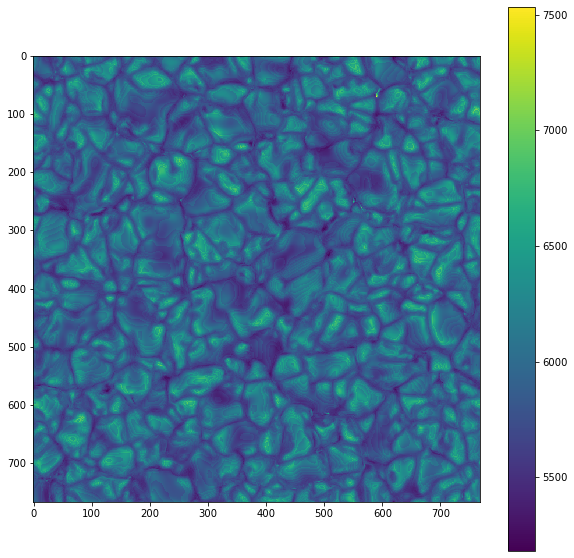

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(T_gas_tau[:,:])
plt.colorbar()

/astro/local/anaconda/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


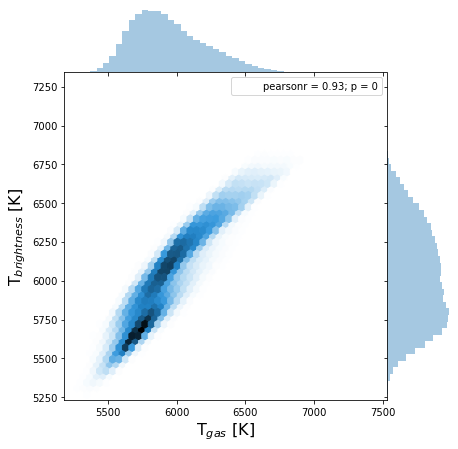

In [35]:
import scipy.stats as stats
h5 = sns.jointplot(T_gas_tau[:,:],T_brightness_ref[:,:],kind='hex',space=0)
h5.set_axis_labels(r'T$_{gas}$ [K]',r'T$_{brightness}$ [K]',fontsize=16)
h5.annotate(stats.pearsonr)

In [36]:
#Spatial coT_gas_taution for each wavelength position per unit time with an FWHM of 0.08 arcsec
#Saptial sampling of the simulation is ~31 km and the spatial resolution of CHROMIS is ~60 km. Assuming an FWHM of 60 km, leads to a standard
# deviation that is given by 60/2.335 km ~ 1 pixel (compared to simulation) in the x direction in the simulation. Hence defining a Gaussian kernel with a std dev =1
from astropy.convolution import Gaussian2DKernel,convolve
gauss_kernel = Gaussian2DKernel(1)
space_conv_Ca_wb=np.zeros((size_intensity[0],size_intensity[1],len(indices)))
for wav in range(len(indices)):
    space_conv_Ca_wb[:,:,wav] = convolve(inten_comb[:,:,indices[wav]],gauss_kernel,normalize_kernel=True,boundary='extend')
    

In [37]:
#plt.plot(wave_chrom,Norm_pre_filter)
from scipy.interpolate import interp1d
Pre_filter = Transmission_chrom
f1 = interp1d(wave_chrom, Pre_filter)
New_tran = f1(wave_wb[indices])

In [38]:
Transmission_chrom.shape

(176,)

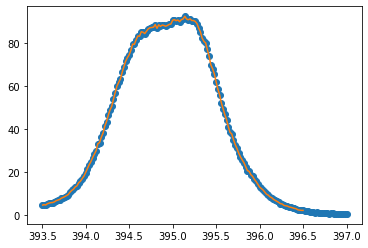

In [39]:
plt.plot(wave_chrom,Pre_filter,'o',wave_wb[indices],New_tran,'-')

In [40]:
N_r = wave_wb[indices]*0
D_r = wave_wb[indices]*0
Norm_new_tran = New_tran/np.max(New_tran)
spec_conv_Ca_wb = np.zeros((size_intensity[0],size_intensity[1]))
for xx in range(size_intensity[0]):
    for yy in range(size_intensity[1]):
        for i in range(len(wave_wb[indices])):
            N_r[i] = (space_conv_Ca_wb[xx,yy,i]*Norm_new_tran[i])
            D_r[i] = Norm_new_tran[i]
        spec_conv_Ca_wb[xx,yy] = np.sum(N_r)/np.sum(D_r)
print('At location X '+format(xx) +' and Y '+format(yy))

At location X 767 and Y 767


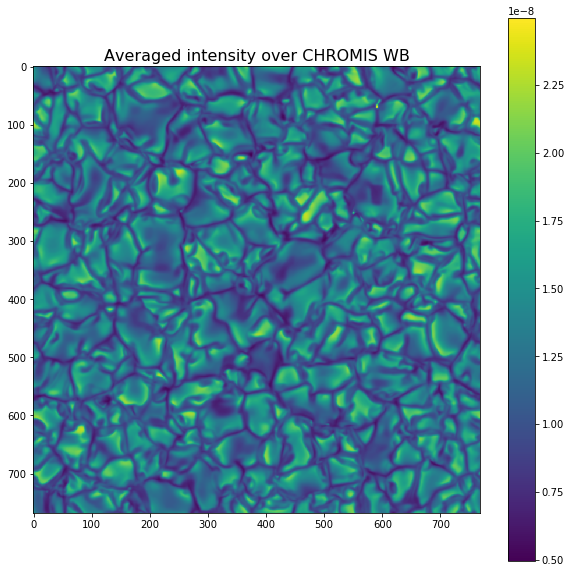

In [41]:
plt.figure(figsize=(10,10))
plt.imshow(spec_conv_Ca_wb)
plt.title('Averaged intensity over CHROMIS WB',fontsize=16)
plt.colorbar()

In [42]:
lamba_ref = 394.61e-9
I_sp = spec_conv_Ca_wb
T_brightness_mean = I_sp*0.
for xx in range(size_intensity[0]):
    for yy in range(size_intensity[1]):
        T_brightness_mean[xx,yy] = radiation_temperature(lambda_ref=lamba_ref,I_sp=I_sp[xx,yy])

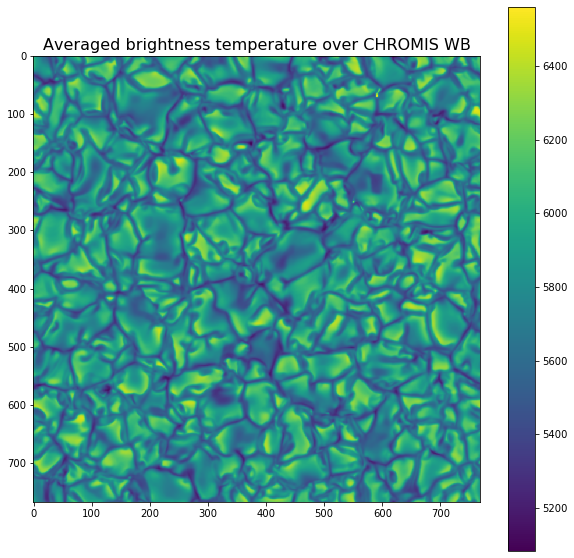

In [45]:
plt.figure(figsize=(10,10))
plt.imshow(T_brightness_mean)
plt.title('Averaged brightness temperature over CHROMIS WB',fontsize=16)
plt.colorbar()

In [46]:
N_r = wave_wb[indices]*0
D_r = wave_wb[indices]*0
Norm_new_tran = New_tran/np.max(New_tran)
tau_mean = np.zeros((size_intensity[0],size_intensity[1]))
for xx in range(size_intensity[0]):
    for yy in range(size_intensity[1]):
        for i in range(len(wave_wb[indices])):
            N_r[i] = (tau_comb[xx,yy,indices[i]]*Norm_new_tran[i])
            D_r[i] = Norm_new_tran[i]
        tau_mean[xx,yy] = np.sum(N_r)/np.sum(D_r)

In [47]:
np.mean(tau_mean)

96372.51717845455

In [48]:
find_nearest(z[0,:],np.mean(tau_mean))

604

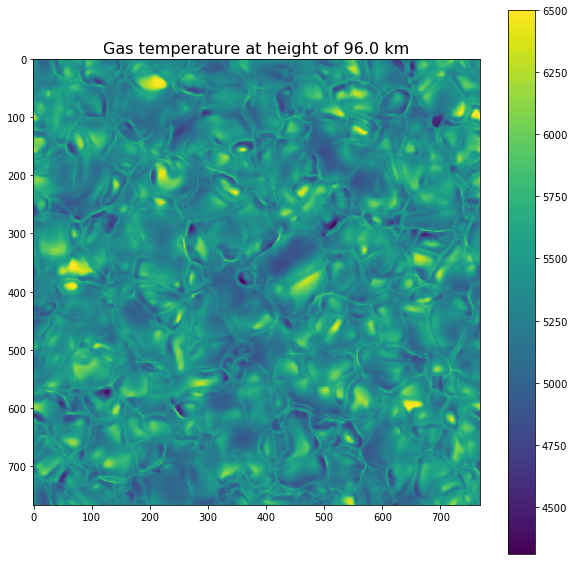

In [49]:
plt.figure(figsize=(10,10))
plt.imshow(temp_gas[0,:,:,604],vmax=6500)
plt.title('Gas temperature at height of '+format(np.round(np.mean(tau_mean)/1e3))+' km',fontsize=16)
plt.colorbar()

/astro/local/anaconda/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


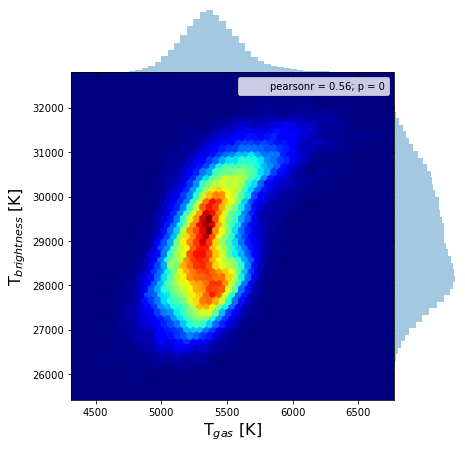

In [50]:
import scipy.stats as stats
h5 = sns.jointplot(temp_gas[0,:,:,604],T_brightness_mean[:,:]*5,kind='hex',space=0,cmap='jet')
h5.set_axis_labels(r'T$_{gas}$ [K]',r'T$_{brightness}$ [K]',fontsize=16)
h5.annotate(stats.pearsonr)

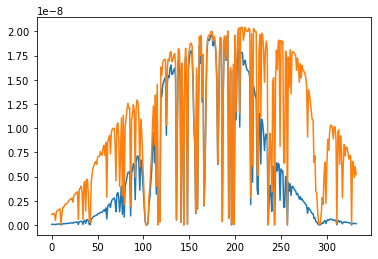

In [51]:
plt.plot(space_conv_Ca_wb[10,10,:]*Norm_new_tran)
plt.plot(space_conv_Ca_wb[10,10,:])

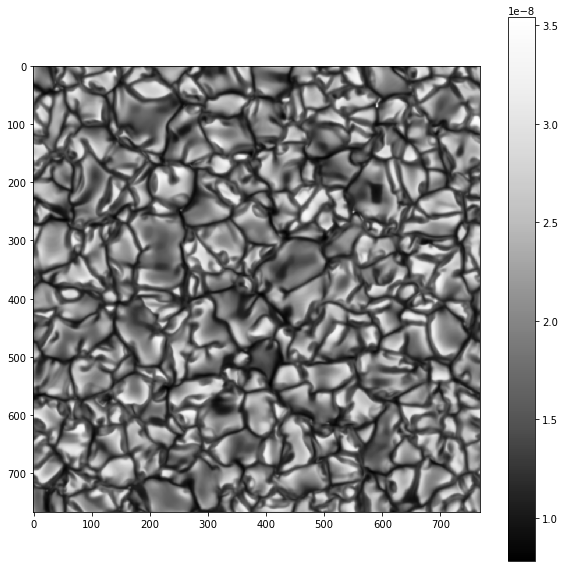

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(space_conv_Ca_wb[:,:,184],cmap='Greys_r')
plt.colorbar()

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(spec_conv_Ca_wb[:,:,184],cmap='Greys_r')
plt.colorbar()

In [29]:
wave_wb[indices[184]]

395.13997853294217

In [77]:
wave_chrom[np.argmax(Transmission_chrom)]

395.14001460000003

In [20]:
lamba_ref = 395.14e-9
I_sp = spec_conv_Ca_wb[:,:,184]
T_brightness = I_sp*0.
for xx in range(size_intensity[0]):
    for yy in range(size_intensity[1]):
        T_brightness[xx,yy] = radiation_temperature(lambda_ref=lamba_ref,I_sp=I_sp[xx,yy])

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(T_brightness*10)
plt.colorbar()

In [53]:
T_brightness.max()

668.2339129174628

In [26]:
plt.plot(wave_wb[indices],tau_comb[200,200,indices]/1e3)
plt.xlabel('wavelength')
plt.ylabel('Height [km]')

Text(0, 0.5, 'Height [km]')

In [25]:
tau_comb[:,:,indices].shape

(768, 768, 333)

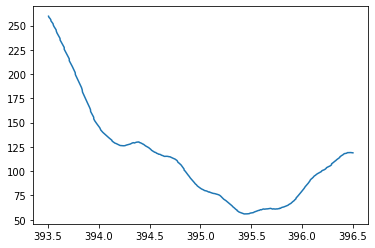

In [91]:
plt.plot(wave_wb[indices],tu_conv/1e3)

In [ ]:
tau_comb

In [92]:
np.mean(tu_conv)/1e3

115.161

In [33]:
z[0,608]/1e3

39.0535

In [32]:
temp_gas.shape

(1, 768, 768, 768)

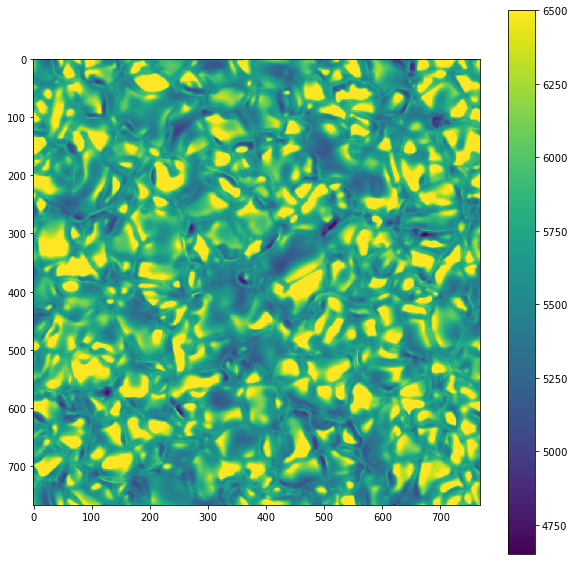

In [35]:
plt.figure(figsize=(10,10))
plt.imshow(temp_gas[0,:,:,608],vmax=6500)
plt.colorbar()

In [60]:
T_gas = temp_gas[0,:,:,600]
T_brightness=T_brightness*10

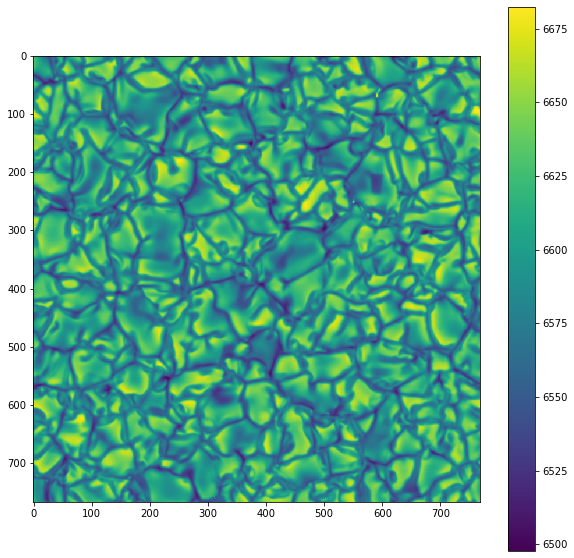

In [36]:
plt.figure(figsize=(10,10))
plt.imshow(T_brightness*10)
plt.colorbar()

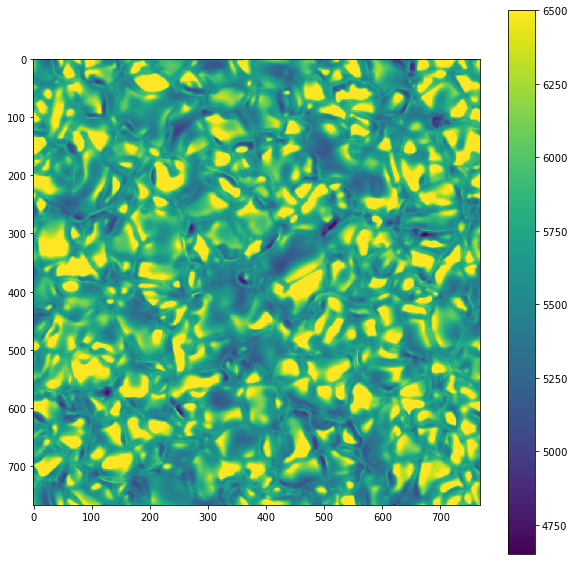

In [37]:
plt.figure(figsize=(10,10))
plt.imshow(temp_gas[0,:,:,608],vmax=6500)
plt.colorbar()

In [73]:
T_gas.max()

6165.4443

In [71]:
T_brightness.max()

6682.339129174628

In [144]:
import seaborn as sns
#h5 = sns.kdeplot(T_gas,data2=T,shade=True,cmap='Reds',ax=axs[5],bw='scott')
h5 = sns.jointplot(T_gas,T_brightness,kind='hex',cmap='jet')
h5.set_axis_labels(r'T$_{gas}$',r'T$_{brightness}$',fontsize=16)

NameError: name 'T_gas' is not defined

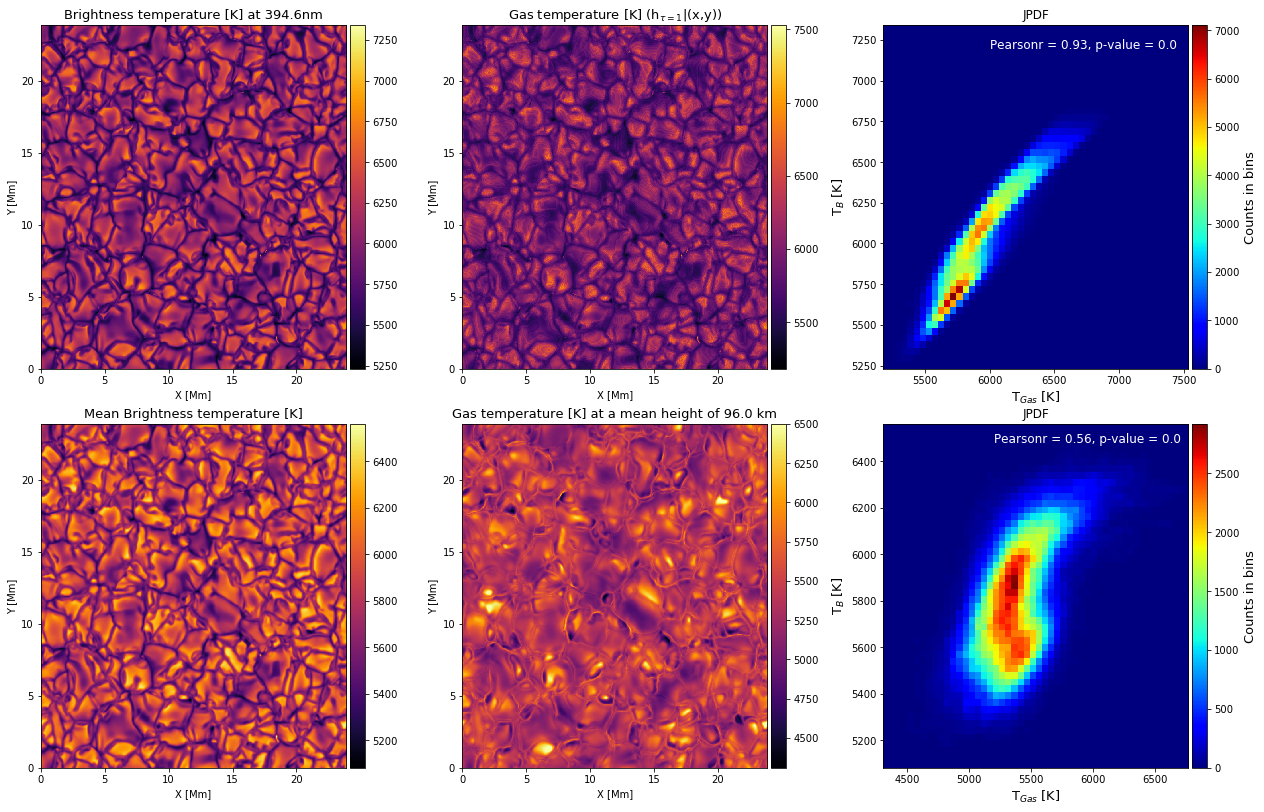

In [59]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs =plt.subplots(2,3,figsize=(18,12),facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.16,wspace=0.3,left=0.05,right=0.95,top=0.93,bottom=0.07)
axs=axs.ravel()

im0=axs[0].imshow(T_brightness_ref,cmap='inferno',origin='lower',extent=[0,768*31.1/1e3,0,768*31.1/1e3],aspect='auto')
divider = make_axes_locatable(axs[0])
cax0 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im0,cax=cax0)
axs[0].set_ylabel('Y [Mm]')
axs[0].set_title('Brightness temperature [K] at 394.6nm',fontsize=13)
axs[0].set_xlabel('X [Mm]')

im1 = axs[1].imshow(T_gas_tau,cmap='inferno',origin='lower',extent=[0,768*31.1/1e3,0,768*31.1/1e3],aspect='auto')
divider = make_axes_locatable(axs[1])
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1,cax=cax1)
axs[1].set_title(r'Gas temperature [K] (h$_{\tau=1}$|(x,y))',fontsize=13)
axs[1].set_xlabel('X [Mm]')
axs[1].set_ylabel('Y [Mm]')

heatmap, xedges, yedges = np.histogram2d(T_gas_tau.flatten(), T_brightness_ref.flatten(), bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im2=axs[2].imshow(heatmap.T, origin='lower' ,extent=extent,aspect='auto',cmap='jet')
divider = make_axes_locatable(axs[2])
cax2 = divider.append_axes("right", size="5%", pad=0.05)
cbar=plt.colorbar(im2,cax=cax2)
cbar.set_label('Counts in bins',fontsize=13)
pearson=stats.pearsonr(T_gas_tau.flatten(),T_brightness_ref.flatten())
axs[2].set_xlabel(r'T$_{Gas}$ [K]',fontsize=13)
axs[2].set_ylabel(r'T$_{B}$ [K]',fontsize=13)
axs[2].set_title('JPDF')
axs[2].text(6000,7200,'Pearsonr = '+format(np.round(pearson[0],decimals=2))+', p-value = '+format(pearson[1]),color='white',fontsize=12 )

im2=axs[3].imshow(T_brightness_mean,cmap='inferno',origin='lower',extent=[0,768*31.1/1e3,0,768*31.1/1e3],aspect='auto')
divider = make_axes_locatable(axs[3])
cax2 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2,cax=cax2)
axs[3].set_ylabel('Y [Mm]')
axs[3].set_title('Mean Brightness temperature [K]',fontsize=13)
axs[3].set_xlabel('X [Mm]')

im3=axs[4].imshow(temp_gas[0,:,:,604],cmap='inferno',origin='lower',extent=[0,768*31.1/1e3,0,768*31.1/1e3],aspect='auto',vmax=6500)
divider = make_axes_locatable(axs[4])
cax3 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im3,cax=cax3)
axs[4].set_ylabel('Y [Mm]')
axs[4].set_title('Gas temperature [K] at a mean height of '+format(np.round(np.mean(tau_mean)/1e3))+' km',fontsize=13)
axs[4].set_xlabel('X [Mm]')

heatmap1, xedges1, yedges1 = np.histogram2d(temp_gas[0,:,:,604].flatten(), T_brightness_mean.flatten(), bins=50)
extent1 = [xedges1[0], xedges1[-1], yedges1[0], yedges1[-1]]
im4=axs[5].imshow(heatmap1.T, origin='lower' ,extent=extent1,aspect='auto',cmap='jet')
divider = make_axes_locatable(axs[5])
cax4 = divider.append_axes("right", size="5%", pad=0.05)
cbar=plt.colorbar(im4,cax=cax4)
cbar.set_label('Counts in bins',fontsize=13)
pearson1=stats.pearsonr(temp_gas[0,:,:,604].flatten(), T_brightness_mean.flatten())
axs[5].set_xlabel(r'T$_{Gas}$ [K]',fontsize=13)
axs[5].set_ylabel(r'T$_{B}$ [K]',fontsize=13)
axs[5].set_title('JPDF')
axs[5].text(5200,6480,'Pearsonr = '+format(np.round(pearson1[0],decimals=2))+', p-value = '+format(pearson1[1]),color='white',fontsize=12 )

plt.savefig('/mn/stornext/u3/souvikb/paper5_images/Comparison_brightness_temp_QS.pdf')

In [147]:
wave_wb[indices].shape

(333,)

In [149]:
index500 = np.argmin(np.abs(wave_wb.data - 500))

TypeError: unsupported operand type(s) for -: 'memoryview' and 'int'

In [155]:
#This part is for writing the indices of the wavelength files where we want to compute the source function and chi. We can then compute the contribution functions. 

f = open('/mn/stornext/u3/souvikb/rh/rh15d/run_Ca_EN/ray.input','w')
f.write('1.00\n')
output = str(len(indices))
for ind in indices:
    output += ' %i' % ind
f.write(output)
f.close()

In [153]:
output = str(len(indices)+1)
output

'334'

In [158]:
wave_wb[indices].shape


(333,)

In [157]:
wave_wb.shape

(874,)